# Comparing qcodes Measurement context manager with qcodes doNd functions

In this example notebook, we want to show how the qcodes Measurement can be simplified by using qcodes doNd functions. Under the hood, qcodes doNd functions use Measurement context manager to perform a measurement. It does not matter which one of these two approaches to be chosen, the result will be the same.

### Necessary imports

In [1]:
from qcodes import initialise_or_create_database_at
import time
import numpy as np
from qcodes.instrument.parameter import Parameter
from qcodes import load_or_create_experiment, Measurement,\
load_by_run_spec
from qcodes.utils.dataset import doNd
from qcodes.dataset.plotting import plot_dataset

### Creating a database or loading it

It is not required to have a database for this notebook, but we would like to have it. We encourage users to open a plottr and view the results of this notebook using its live plotting feature (more info [How to use plottr with QCoDeS for live plotting](../plotting/How-to-use-Plottr-with-QCoDeS-for-live-plotting.ipynb))

In [2]:
initialise_or_create_database_at('doNd.db')

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 338.66it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.72it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.82it/s]


### Setting up parameters

For the sake of this notebook, we define some parameters for measurements and not use any specific instrument. In real experiments, measurement paramaters will be most likely direct or indirect parameters of instruments.

In [3]:
x = Parameter('x', set_cmd=None) # Sweep parameter
y = Parameter('y', set_cmd=None) # Sweep parameter
z1 = Parameter('z1', get_cmd=lambda: np.cos(x())) # Output parameter
z2 = Parameter('z2', get_cmd=lambda: np.sin(x())) # Output parameter
z3 = Parameter('z3', get_cmd=lambda: np.cos(x())*np.sin(y())) # Output parameter

### One-dimensional measurement

Let's start with a simple one-dimensional case, where we sweep over the parameter 'x' and retrieve parameter 'z1' and 'z2' calculated as cos and sin on those swept 'x' points, repectively. We intentionally want to have two independent 'z1' and 'z2' calculated parameters to show how we can have more than one output parameter in the Measurement and doNd.

##### Measurement

In [4]:
# Creating an experiment
exp = load_or_create_experiment('one_dimensional_Measurement', sample_name='no sample')

# Setting up Measurement
meas = Measurement(exp)
meas.register_parameter(x)
meas.register_parameter(z1, setpoints=(x,))
meas.register_parameter(z2, setpoints=(x,))
meas.write_period = 2

# Running Measurement
t1 = time.time()
with meas.run() as datasaver:
    for sweep in np.linspace(-5, 5, 51): # sweep points for x
        x(sweep) # Setting x at the sweep points
        datasaver.add_result(
            ('x', x()),
            ('z1', z1()),
            ('z2', z2())
            )
        time.sleep(0.1) # Can be removed if there is no intention to see a live plot
t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Starting experimental run with id: 1. 
Meaurement took 5.6161181926727295 seconds


([<AxesSubplot:title={'center':'Run #1, Experiment one_dimensional_Measurement (no sample)'}, xlabel='x', ylabel='z1'>,
  <AxesSubplot:title={'center':'Run #1, Experiment one_dimensional_Measurement (no sample)'}, xlabel='x', ylabel='z2'>],
 [None, None])

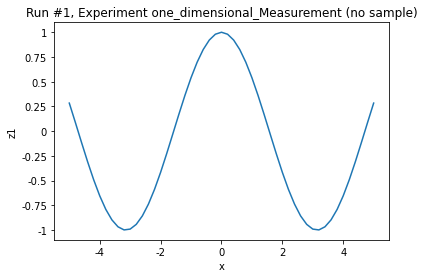

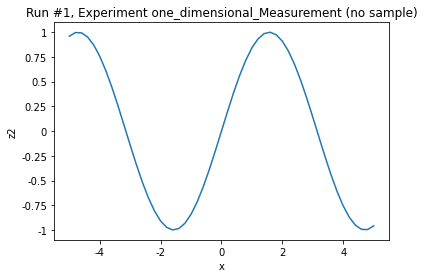

In [5]:
dataset1 = load_by_run_spec(experiment_name='one_dimensional_Measurement',\
                           captured_run_id=1)
plot_dataset(dataset1)

##### do1d

Now, we get the above result using do1d, instead. do_plot is set to True for showing the output result and avoiding plotting like we did for the Measurement section. Remember, having this falg set causes creation of PNG and PDF of the plot. Usually, users like to see live plotting using tools such as plottr. Thus, do_plot can be left out to be set, which the default is False.

Starting experimental run with id: 2. 
Meaurement took 6.4778125286102295 seconds


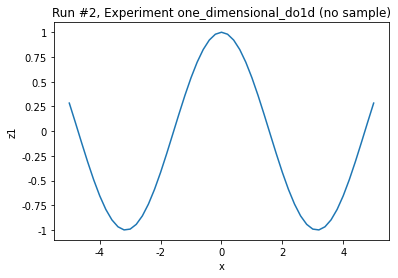

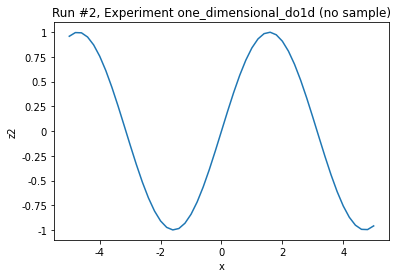

In [6]:
# Creating an experiment
exp = load_or_create_experiment('one_dimensional_do1d', sample_name='no sample')

# Running measurement with do1d
t1 = time.time()
doNd.do1d(x, -5, 5, 51, 0.1, z1, z2, do_plot=True)
t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Note that in the Measurement section, we introduced time.sleep() to have delay between sweep points. In doNds, it is not possible to have such sleep, instead the delay can be introduced by setting the forth number (post_delay) of the sweep parameter to a number bigger than zero. 

### Two-dimensional measurement

Now, we want to run a measurement, where we calcalate 'z3' parameter values depending on 'x' and 'y'. So, we will have two-dimensional sweep and the result would be a color map.

##### Measurement

In [7]:
# In the above cell, we intrduced a delay of 0.1 second for x parameter.
# As we don't want to have that delay affects here, we do this:
x.post_delay = 0

# Creating an experiment
exp = load_or_create_experiment('two_dimensional_Measurement', sample_name='no sample')

# Setting up Measurement
meas = Measurement(exp)
meas.register_parameter(x)
meas.register_parameter(y)
meas.register_parameter(z3, setpoints=(x, y))
meas.write_period = 2

# Running Measurement
t1 = time.time()
with meas.run() as datasaver:
    for x_sweep in np.linspace(-5, 5, 51): # sweep points for x
        x(x_sweep) # Setting x at the x_sweep points
        for y_sweep in np.linspace(-5, 5, 51): # sweep points for y
            y(y_sweep) # Setting y at the y_sweep points
            datasaver.add_result(
                ('x', x()),
                ('y', y()),
                ('z3', z3()),
            )
        time.sleep(0.1) # The sleep time is set for the outer loop (x sweep) to run faster

t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Starting experimental run with id: 3. 
Meaurement took 5.663341999053955 seconds


([<AxesSubplot:title={'center':'Run #3, Experiment two_dimensional_Measurement (no sample)'}, xlabel='x', ylabel='y'>],
 [<matplotlib.colorbar.Colorbar at 0x25efa0900c8>])

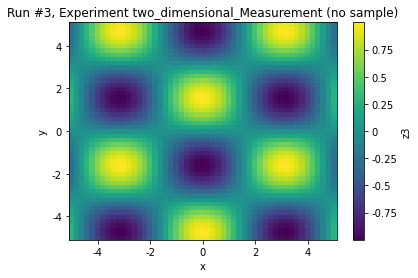

In [8]:
dataset2 = load_by_run_spec(experiment_name='two_dimensional_Measurement',\
                           captured_run_id=3)
plot_dataset(dataset2)

##### do2d

Now, we get the above result using do2d, instead.

Starting experimental run with id: 4. 
Meaurement took 6.5548927783966064 seconds


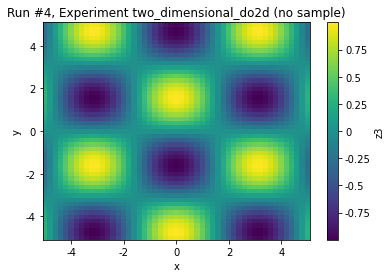

In [9]:
# Creating an experiment
exp = load_or_create_experiment('two_dimensional_do2d', sample_name='no sample')

# Running measurement with do2d (only x sweep has delay of 0.1, y delay is set to zero)
t1 = time.time()
doNd.do2d(x, -5, 5, 51, 0.1, y, -5, 5, 51, 0, z3, do_plot=True)
t2 = time.time()
print(f'Meaurement took {t2-t1} seconds')

Just like one-dimensional case, in two-dimensional sweeping, it is possible to have more than one output parameter.